In [284]:
import itertools
import pandas as pd
import numpy as np
import scipy.stats
import re
import math
import matplotlib as mlp
import matplotlib.pyplot as plt
import matplotlib.backends.backend_agg
import matplotlib.figure
import seaborn as sns
import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.metrics import roc_curve, roc_auc_score

In [285]:
cars_dataset = pd.read_csv('C:/Users/aleja/Cars-Value-Predictor/cars-features-dataset.csv')
cars_dataset.drop(columns='Unnamed: 0', inplace=True)
print(cars_dataset.shape)
cars_dataset.head()

(16920, 18)


,Make,Model,Year,Mileage,Transmission,Engine,Exterior Color,Interior Color,MPG,Fuel Type,Drive Type,Location (City),Location (State),Style,Condition (Accidents),Options Level,Bed Length,Price
0,Ford,Focus,2014.0,"35,795",Automatic,2.0L Inline-4 Gas,NaN,Charcoal Black,26 cty / 36 hwy,Gas,FWD,Tacoma,WA,SE Hatchback,2 reported accidents,Standard,NaN,"7,999"
1,Ford,F-150,2015.0,"128,146",Automatic,2.7L V-6 Gas Turbocharged,Unknown,Medium Earth Gray,19 cty / 26 hwy,Gas,RWD,Waxahachie,TX,XL SuperCrew 6.5\' Box RWD,0 reported accidents,NaN,Standard Bed,"15,991"
2,Mercedes-Benz,E-Class,2004.0,"135,000",Automatic,5.0L V-8 Gas,Black,Beige,16 cty / 22 hwy,Gas,AWD,Covina,CA,E 500 4MATIC Wagon,0 reported accidents,Standard,NaN,"5,950"
3,Hyundai,Elantra,2011.0,"135,670",Automatic,1.8L Inline-4 Gas,NaN,Gray,28 cty / 38 hwy,Gas,FWD,Miami,FL,NaN,0 reported accidents,Standard,NaN,"3,999"
4,Toyota,Prius,2012.0,"152,543",Automatic,1.8L Inline-4 Hybrid,White,Biege,51 cty / 48 hwy,Hybrid,FWD,Byhalia,MS,Five,1 reported accidents,Standard,NaN,"6,500"


## Exploratory Data Analysis

In [286]:
cars_dataset.dtypes

Make                      object
Model                     object
Year                     float64
Mileage                   object
Transmission              object
Engine                    object
Exterior Color            object
Interior Color            object
MPG                       object
Fuel Type                 object
Drive Type                object
Location (City)           object
Location (State)          object
Style                     object
Condition (Accidents)     object
Options Level             object
Bed Length                object
Price                     object
dtype: object

In [287]:
cars_dataset.isnull().sum(axis=0)

Make                       896
Model                      923
Year                       822
Mileage                    349
Transmission               386
Engine                    3545
Exterior Color            5840
Interior Color            1285
MPG                        367
Fuel Type                  336
Drive Type                 284
Location (City)            713
Location (State)           748
Style                     1747
Condition (Accidents)      781
Options Level             2241
Bed Length               15641
Price                      916
dtype: int64

In [288]:
cols_by_nulls = cars_dataset.isnull().sum().sort_values(ascending=False).to_dict()
cols_by_nulls

{'Bed Length': 15641,
 'Exterior Color': 5840,
 'Engine': 3545,
 'Options Level': 2241,
 'Style': 1747,
 'Interior Color': 1285,
 'Model': 923,
 'Price': 916,
 'Make': 896,
 'Year': 822,
 'Condition (Accidents)': 781,
 'Location (State)': 748,
 'Location (City)': 713,
 'Transmission': 386,
 'MPG': 367,
 'Mileage': 349,
 'Fuel Type': 336,
 'Drive Type': 284}

This high quantity of allegedly null values is due to lack of information when inputting specifications in each car listing from its owner or merchant.
Some of them will be dropped but most of them will be labeled as another data.

In [289]:
cars_dataset.dropna(subset=['Make', 'Model'], inplace=True)
cars_dataset.shape

(15983, 18)

Make and model are too important to have as an specific information for each row, so the ones were Make and Model are missing were dropped.

Now, 'Drive Type' will be analyzed.

In [290]:
cars_dataset['Drive Type'].value_counts()

FWD        9347
AWD        2648
4WD        2144
RWD        1813
Unknown       8
Name: Drive Type, dtype: int64

In [291]:
cars_dataset['Drive Type'].isnull().sum()

23

This variable has just 23 null values. In addition to that there is one category called 'Unknown', which has only 8 occurrences.
The rows presenting these values are going to be eliminated.

In [292]:
cars_dataset["Drive Type"] = cars_dataset["Drive Type"].apply(lambda dt: (dt, np.NaN)[dt == 'Unknown'])
cars_dataset.dropna(subset=["Drive Type"], inplace=True)

In [293]:
cars_dataset.shape

(15952, 18)

The next variable with the least amount of null values is 'Fuel Type'.

In [294]:
print(cars_dataset['Fuel Type'].value_counts())
cars_dataset['Fuel Type'].isnull().sum()

Gas         14999
Hybrid        482
Diesel        266
Plug-In        99
Electric       64
Hydrogen        3
CNG             2
Name: Fuel Type, dtype: int64


37

In [295]:
cars_dataset['Fuel Type'] = cars_dataset['Fuel Type'].apply(lambda ft: (ft, np.NaN)[ft in ['Hydrogen', 'CNG']])
cars_dataset.dropna(subset=['Fuel Type'], inplace=True)

In [296]:
cars_dataset.shape

(15910, 18)

'Mileage' column comes on.

In [297]:
print(cars_dataset['Mileage'].value_counts())
cars_dataset['Mileage'].isnull().sum()

29,842     20
148,040    19
152,997    18
51,821     16
104,968    15
           ..
18,346      1
78,511      1
208,295     1
39,433      1
80,173      1
Name: Mileage, Length: 6271, dtype: int64


12

In [298]:
sorted(list(map(lambda m: str(m), cars_dataset['Mileage'].unique())), reverse=True)

['nan',
 '99,999',
 '99,841',
 '99,835',
 '99,729',
 '99,721',
 '99,707',
 '99,699',
 '99,665',
 '99,658',
 '99,625',
 '99,617',
 '99,613',
 '99,612',
 '99,600',
 '99,547',
 '99,440',
 '99,426',
 '99,424',
 '99,393',
 '99,386',
 '99,304',
 '99,263',
 '99,255',
 '99,238',
 '99,223',
 '99,137',
 '99,121',
 '99,112',
 '99,111',
 '99,102',
 '99,094',
 '99,065',
 '98,940',
 '98,893',
 '98,849',
 '98,840',
 '98,832',
 '98,830',
 '98,815',
 '98,794',
 '98,764',
 '98,750',
 '98,721',
 '98,715',
 '98,693',
 '98,681',
 '98,634',
 '98,615',
 '98,611',
 '98,609',
 '98,601',
 '98,600',
 '98,502',
 '98,459',
 '98,443',
 '98,429',
 '98,399',
 '98,358',
 '98,356',
 '98,326',
 '98,276',
 '98,175',
 '98,174',
 '98,141',
 '98,134',
 '98,087',
 '98,073',
 '98,026',
 '98',
 '97,922',
 '97,891',
 '97,860',
 '97,814',
 '97,813',
 '97,773',
 '97,762',
 '97,746',
 '97,687',
 '97,632',
 '97,586',
 '97,565',
 '97,358',
 '97,356',
 '97,329',
 '97,202',
 '97,165',
 '97,150',
 '97,116',
 '97,077',
 '97,071',
 '97,0

In [299]:
cars_dataset.dropna(subset=['Mileage'], inplace=True)

In [300]:
def mileage_lapse(mileage):
    mileage = str(mileage)
    if len(mileage) == 7:
        return "100,000 or more"
    elif len(mileage) == 6:
        return str(mileage[0])+"0,000 - "+mileage[0]+"9,999"
    else:
        return "Less than 10,000"

In [301]:
cars_dataset['Mileage'] = cars_dataset['Mileage'].apply(mileage_lapse)
cars_dataset['Mileage'].value_counts()

30,000 - 39,999     2974
100,000 or more     2923
20,000 - 29,999     2613
40,000 - 49,999     1490
10,000 - 19,999     1460
Less than 10,000     895
50,000 - 59,999      779
90,000 - 99,999      748
60,000 - 69,999      719
80,000 - 89,999      673
70,000 - 79,999      624
Name: Mileage, dtype: int64

Following into the variables list with the least null values, 'MPG' comes up.

In [302]:
print(cars_dataset['MPG'].value_counts())
cars_dataset['MPG'].isnull().sum()

17 cty / 25 hwy      603
29 cty / 37 hwy      592
N/A cty / N/A hwy    543
28 cty / 39 hwy      381
26 cty / 33 hwy      365
                    ... 
51 cty / 46 hwy        1
40 cty / 45 hwy        1
129 cty / 102 hwy      1
12 cty / 14 hwy        1
85 cty / 82 hwy        1
Name: MPG, Length: 271, dtype: int64


18

This column has only 18 null values, however, they are also represented as a True value as 'N/A cty / N/A hwy', as seen down below.
As there are around 500 of these values, they will be categorized as well.

In [303]:
sorted(list(cars_dataset.dropna(subset=['MPG'])['MPG'].unique()))

['10 cty / 16 hwy',
 '10 cty / 17 hwy',
 '101 cty / 93 hwy',
 '102 cty / 105 hwy',
 '104 cty / 91 hwy',
 '106 cty / 92 hwy',
 '11 cty / 15 hwy',
 '11 cty / 16 hwy',
 '11 cty / 17 hwy',
 '11 cty / 18 hwy',
 '11 cty / N/A hwy',
 '12 cty / 14 hwy',
 '12 cty / 16 hwy',
 '12 cty / 17 hwy',
 '12 cty / 18 hwy',
 '12 cty / 19 hwy',
 '120 cty / 112 hwy',
 '121 cty / 103 hwy',
 '122 cty / 108 hwy',
 '122 cty / 93 hwy',
 '124 cty / 94 hwy',
 '126 cty / 101 hwy',
 '126 cty / 105 hwy',
 '126 cty / 99 hwy',
 '129 cty / 102 hwy',
 '13 cty / 16 hwy',
 '13 cty / 17 hwy',
 '13 cty / 18 hwy',
 '13 cty / 19 hwy',
 '13 cty / 20 hwy',
 '13 cty / 21 hwy',
 '13 cty / 22 hwy',
 '137 cty / 111 hwy',
 '14 cty / 17 hwy',
 '14 cty / 18 hwy',
 '14 cty / 19 hwy',
 '14 cty / 20 hwy',
 '14 cty / 21 hwy',
 '14 cty / 22 hwy',
 '14 cty / 23 hwy',
 '14 cty / 24 hwy',
 '15 cty / 17 hwy',
 '15 cty / 18 hwy',
 '15 cty / 19 hwy',
 '15 cty / 20 hwy',
 '15 cty / 21 hwy',
 '15 cty / 22 hwy',
 '15 cty / 23 hwy',
 '15 cty / 24 hwy

In [266]:
re.findall('[0-9]+ c', '121 cty / 103 hwy')[0][:-2]

'121'

In [267]:
def MPG_categorize(MPG):
    if MPG in ['N/A cty / N/A hwy', np.NaN]:
        return 'Another'
    else:
        cty = int(re.findall('[0-9]+ c', str(MPG))[0][:-2])
        hwy = re.findall('/ [0-9]+', str(MPG))
        if hwy == []:
            return 'Another'
        elif cty >= 60:
            return 'up from 60 cty / up from 50 hwy'
        else:
            hwy = int(hwy[0][2:])
            return str(cty)[0] + "0-" + str(cty)[0] + "9 cty / " + str(hwy)[0] + "0-" + str(hwy)[0] + "9 hwy"

cars_dataset['MPG'] = cars_dataset['MPG'].apply(MPG_categorize)
cars_dataset['MPG'].value_counts()

20-29 cty / 30-39 hwy              7011
10-19 cty / 20-29 hwy              4193
20-29 cty / 20-29 hwy              1899
30-39 cty / 40-49 hwy               635
Another                             562
30-39 cty / 30-39 hwy               482
10-19 cty / 10-19 hwy               433
40-49 cty / 40-49 hwy               303
10-19 cty / 30-39 hwy               104
up from 60 cty / up from 50 hwy      94
20-29 cty / 40-49 hwy                81
40-49 cty / 30-39 hwy                45
50-59 cty / 40-49 hwy                41
50-59 cty / 50-59 hwy                 9
30-39 cty / 20-29 hwy                 6
Name: MPG, dtype: int64

30, 40 and 50 cty categories are being gathered so outliers disappear.

In [270]:
def MPG_categorize2(MPG):
    if MPG in ['30-39 cty / 20-29 hwy', '30-39 cty / 30-39 hwy']:
        return '30-39 cty / 20-39 hwy'
    elif MPG in ['50-59 cty / 40-49 hwy', '50-59 cty / 50-59 hwy']:
        return '50-59 cty / 40-59 hwy'
    elif MPG in ['40-49 cty / 30-39 hwy', '40-49 cty / 40-49 hwy']:
        return '40-49 cty / 30-49 hwy'
    else:
        return MPG
    

cars_dataset['MPG'] = cars_dataset['MPG'].apply(MPG_categorize2)
cars_dataset['MPG'].value_counts()

20-29 cty / 30-39 hwy              7011
10-19 cty / 20-29 hwy              4193
20-29 cty / 20-29 hwy              1899
30-39 cty / 40-49 hwy               635
Another                             562
30-39 cty / 20-39 hwy               488
10-19 cty / 10-19 hwy               433
40-49 cty / 30-49 hwy               348
10-19 cty / 30-39 hwy               104
up from 60 cty / up from 50 hwy      94
20-29 cty / 40-49 hwy                81
50-59 cty / 40-59 hwy                50
Name: MPG, dtype: int64

'Transmission' feature presents only two true values, as logically thought. We will just get rid of null values then.

In [272]:
print(cars_dataset['Transmission'].isnull().sum())
cars_dataset['Transmission'].value_counts()

13


Automatic    15406
Manual         479
Name: Transmission, dtype: int64

In [273]:
cars_dataset.dropna(subset=['Transmission'], inplace=True)

In [282]:
cars_dataset['Location (State)'].unique()

array(['WA', 'TX', 'CA', 'FL', 'MS', 'VA', 'OH', 'AL', 'IN', 'OK', 'GA',
       'NY', 'MA', 'IL', 'NJ', 'TN', 'NC', 'MO', 'ME', 'OR', 'MD', 'MN',
       'AZ', 'WI', 'SC', nan, 'LA', 'CO', 'KY', 'NM', 'AR', 'PA', 'CT',
       'KS', 'NV', 'ID', 'UT', 'IA', 'HI', 'NH', 'MI', 'MT', 'NE', 'WY',
       'AK', 'DE', 'WV', 'VT', 'SD', 'RI', 'UK', 'ND', 'SO'], dtype=object)

In [283]:
cars_dataset['Location (State)'].unique().shape[0]
cars_dataset.dropna(subset=['Location (State)'], inplace=True)
cars_dataset.shape

(15763, 18)

'Bed Length' is next to go through.

In [66]:
print("'Bed Length' column has", cars_dataset["Bed Length"].isnull().sum(), "null values.")
print("The other ones (", cars_dataset["Bed Length"].notnull().sum(), ") are:", sep="")
cars_dataset['Bed Length'].value_counts()

'Bed Length' column has 14722 null values.
The other ones (1230) are:


Short Bed       576
Standard Bed    535
Long Bed        119
Name: Bed Length, dtype: int64

As seen above the bed length is null for almost all cases, so it will be discarded.

In [10]:
cars_dataset.drop(columns='Bed Length', inplace=True)
cars_dataset.columns

Index(['Make', 'Model', 'Year', 'Mileage', 'Transmission', 'Engine',
       'Exterior Color', 'Interior Color', 'MPG', 'Fuel Type', 'Drive Type',
       'Location (City)', 'Location (State)', 'Style', 'Condition (Accidents)',
       'Options Level', 'Price'],
      dtype='object')

In [67]:
cols_by_nulls.pop("Bed Length")

15641

In [68]:
print("Exterior Color has", cols_by_nulls['Exterior Color'], "null values")
print(cars_dataset['Exterior Color'].value_counts().sum(), "not null values and values count:", cars_dataset['Exterior Color'].nunique())
cars_dataset['Exterior Color'].value_counts()

Exterior Color has 5840 null values
10735 not null values and values count: 569


Black             774
Oxford White      426
Gray              393
Summit White      393
White             367
                 ... 
Guard Metallic      1
Black Stone         1
Beige / Tan         1
Tungsten Pearl      1
Cabo Bronze         1
Name: Exterior Color, Length: 569, dtype: int64

In [13]:
list(cars_dataset['Exterior Color'].value_counts().index)

['Black',
 'Oxford White',
 'Gray',
 'Summit White',
 'White',
 'Super White',
 'Crystal Black Pearl',
 'Super Black',
 'Gun Metallic',
 'Silver Ice Metallic',
 'Shadow Black',
 'Glacier White',
 'Silver',
 'White Orchid Pearl',
 'Fresh Powder',
 'Magnetic Metallic',
 'Unknown',
 'Brilliant Silver',
 'Granite Pearlcoat',
 'Polar White',
 'Blue',
 'Magnetic Black',
 'Red',
 'Jet Black',
 'Agate Black',
 'Black Sand Pearl',
 'Pearl White',
 'Quartz White Pearl',
 'Phantom Black',
 'Predawn Gray Mica',
 'Taffeta White',
 'White Diamond Pearl',
 'Ice Silver Metallic',
 'Billet Clearcoat',
 'Clear White',
 'Pure White',
 'Alpine White',
 'Snow White Pearl',
 'Sparkling Silver',
 'Aurora Black',
 'Symphony Silver',
 'Eminent White Pearl',
 'Scarlet Red',
 'Ebony Black',
 'Caspian Blue',
 'Deep Blue Pearl',
 'Dark Gray Metallic',
 'Race Red',
 'Gold',
 'Black Obsidian',
 'Vice White',
 'Onyx Black',
 'Crystal White Pearl',
 'Blizzard Pearl',
 'Magnetic',
 'Brown',
 'Black Clearcoat',
 'Graphi

'Exterior Color' has a lot of unique values, but they can be regrouped given that these values represent almost the same color for each case, by category.

In [69]:
cars_dataset['Exterior Color'].value_counts()

Black             774
Oxford White      426
Gray              393
Summit White      393
White             367
                 ... 
Guard Metallic      1
Black Stone         1
Beige / Tan         1
Tungsten Pearl      1
Cabo Bronze         1
Name: Exterior Color, Length: 569, dtype: int64

The following function will check whether the passed color names belong to the same category.

In [70]:
def color_in(color, *argc):
    checks = []
    for arg in argc:
        if arg in str(color).lower():
            checks.append(True)
        else:
            checks.append(False)
    if any(checks):
        return True
    else:
        return False

Now, this function will tell if the conditions are met so that it categorizes the original values to this set-up. 

In [71]:
def ext_colors_categorize(ext_color):
    if color_in(ext_color, "black") or "Obsidian" == ext_color:
        return "Black"
    elif color_in(ext_color, "white", "glacier") or ext_color in ["Fresh Powder", "Blizzard Pearl", "Starfire Pearl"]:
        return "White"
    elif color_in(ext_color, "green"):
        return "Green"
    elif color_in(ext_color, "blue", "aqua"):
        return "Blue"
    elif color_in(ext_color, "silver", "gray", "magnetic", "pearlcoat", "tungsten", "graphite", "gun", "platinum", "titanium", "billet"):
        return "Silver or Grey"
    elif color_in(ext_color, "red", "cherry", "ruby", "sun", "rosso", "scarlet"):
        return "Red"
    elif color_in(ext_color, "gold"):
        return "Gold"
    elif color_in(ext_color, "brown", "beige"):
        return "Beige or Brown"
    elif color_in(ext_color, "yellow"):
        return "Yellow"
    else:
        return "Unknown"

In [72]:
cars_dataset['Exterior Color'] = cars_dataset['Exterior Color'].apply(ext_colors_categorize)

In [73]:
cars_dataset['Exterior Color'].value_counts()

Unknown           5793
White             3297
Black             2647
Silver or Grey    2590
Blue               835
Red                649
Beige or Brown      59
Gold                53
Green               24
Yellow               5
Name: Exterior Color, dtype: int64

Like there are just a few cases where the vehicles are yellow or green, we will get rid of these values.

In [19]:
colors_to_drop = list(cars_dataset['Exterior Color'].value_counts().index[-4:])
colors_to_drop

['Beige or Brown', 'Gold', 'Green', 'Yellow']

In [20]:
indexes = []


for color in colors_to_drop:
    indexes += list(cars_dataset[cars_dataset["Exterior Color"] == color].index)
    
    
cars_dataset.drop(indexes, inplace=True)
cars_dataset.shape

(15819, 17)

Text(0.5, 1.0, 'Exterior colors by occurrences')

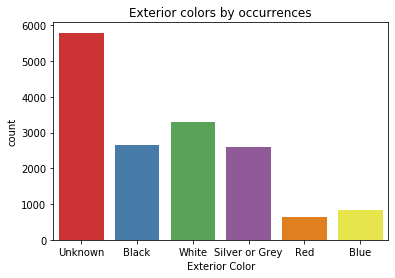

In [21]:
ax = sns.countplot(x="Exterior Color", data=cars_dataset, palette="Set1")
ax.set_title("Exterior colors by occurrences")

Now, 'Engine' will be analyzed.

In [22]:
cars_dataset['Engine'].isnull().sum()

3006

In [23]:
cars_dataset['Engine'].value_counts()

2.5L Inline-4 Gas            1988
1.8L Inline-4 Gas            1369
2.4L Inline-4 Gas            1365
3.6L V-6 Gas                 1327
2.0L Inline-4 Gas            1289
                             ... 
3.0L V-6 Hybrid                 1
1.0L Inline-3 Gas               1
3.4L V-6 Gas                    1
5.0L V-10 Gas                   1
2.9L V-6 Gas Turbocharged       1
Name: Engine, Length: 122, dtype: int64

We are going to check on all the variants for each 'Inline', 'Flat' and 'Vs' engines, so we can filter them into more crowded categories

In [24]:
sorted(cars_dataset['Engine'].value_counts().index.to_list())

['0.6L Inline-2 Plug-In',
 '1.0L Inline-3 Gas',
 '1.2L Inline-3 Gas',
 '1.3L Inline-4 Hybrid',
 '1.4L Inline-4 Gas',
 '1.4L Inline-4 Plug-In',
 '1.5L Inline-4 Gas',
 '1.5L Inline-4 Hybrid',
 '1.5L Inline-4 Plug-In',
 '1.6L Inline-4 Gas',
 '1.6L Inline-4 Hybrid',
 '1.7L Inline-4 Gas',
 '1.8L Inline-4 CNG',
 '1.8L Inline-4 Gas',
 '1.8L Inline-4 Hybrid',
 '1.8L Inline-4 Plug-In',
 '2.0L Flat-4 Gas',
 '2.0L Inline-4 Gas',
 '2.0L Inline-4 Hybrid',
 '2.0L Inline-4 Plug-In',
 '2.0L V-4 Gas Turbocharged',
 '2.2L Inline-4 Gas',
 '2.3L Inline-4 Gas',
 '2.3L V-4 Gas Turbocharged',
 '2.4L Inline-4 Gas',
 '2.4L Inline-4 Hybrid',
 '2.4L Inline-5 Gas',
 '2.5L Flat-4 Gas',
 '2.5L Flat-6 Gas',
 '2.5L Inline-4 Gas',
 '2.5L Inline-4 Hybrid',
 '2.5L Inline-5 Gas',
 '2.5L Inline-6 Gas',
 '2.5L V-6 Gas',
 '2.7L Flat-6 Gas',
 '2.7L Inline-4 Gas',
 '2.7L V-6 Gas',
 '2.7L V-6 Gas Turbocharged',
 '2.8L V-6 Gas',
 '2.9L Inline-4 Gas',
 '2.9L V-6 Gas Turbocharged',
 '3.0L Flat-6 Gas',
 '3.0L Inline-6 Gas',
 '3.0L

In [25]:
for j in ["Inline", "Flat", "V"]:

    for i in cars_dataset['Engine'].value_counts().index.to_list():
        if j in i:
            print(i)

2.5L Inline-4 Gas
1.8L Inline-4 Gas
2.4L Inline-4 Gas
2.0L Inline-4 Gas
1.6L Inline-4 Gas
2.0L Inline-4 Hybrid
1.8L Inline-4 Hybrid
3.0L Inline-6 Gas
2.5L Inline-4 Hybrid
1.5L Inline-4 Gas
2.4L Inline-4 Hybrid
0.6L Inline-2 Plug-In
1.5L Inline-4 Hybrid
1.4L Inline-4 Plug-In
2.5L Inline-5 Gas
2.0L Inline-4 Plug-In
3.2L Inline-6 Gas
2.2L Inline-4 Gas
2.7L Inline-4 Gas
1.2L Inline-3 Gas
2.3L Inline-4 Gas
4.2L Inline-6 Gas
2.5L Inline-6 Gas
1.8L Inline-4 Plug-In
1.3L Inline-4 Hybrid
4.7L Inline-8 Gas
3.7L Inline-5 Gas
1.5L Inline-4 Plug-In
2.4L Inline-5 Gas
1.6L Inline-4 Hybrid
4.0L Inline-6 Gas
2.9L Inline-4 Gas
1.8L Inline-4 CNG
1.4L Inline-4 Gas
3.5L Inline-5 Gas
1.7L Inline-4 Gas
1.0L Inline-3 Gas
2.5L Flat-4 Gas
2.0L Flat-4 Gas
3.8L Flat-6 Gas
3.6L Flat-6 Gas
3.0L Flat-6 Gas
2.7L Flat-6 Gas
2.5L Flat-6 Gas
3.4L Flat-6 Gas
3.2L Flat-6 Gas
3.6L V-6 Gas
3.5L V-6 Gas
5.3L V-8 Gas
5.7L V-8 Gas
4.0L V-6 Gas
3.5L V-6 Gas Turbocharged
5.0L V-8 Gas
6.0L V-8 Gas
3.7L V-6 Gas
6.2L V-8 Gas
3.8L V

In [26]:
def engine_categorize(engine_type):
    if "V-" in engine_type:
        return re.findall("V.+", engine_type)[0]
    elif "Inline" in engine_type:
        return re.findall("I.+", engine_type)[0]
    elif "Flat" in engine_type:
        return re.findall("F.+", engine_type)[0]
    else:
        return "Another"

In [27]:
re.findall("V-[1-8][0-2]?", "5.4L V-10 Gas Supercharged")

['V-10']

In [28]:
cars_dataset['Engine'] = cars_dataset['Engine'].astype(str)
cars_dataset['Engine'].apply(engine_categorize).value_counts()

Inline-4 Gas             6482
V-6 Gas                  3302
Another                  3121
V-8 Gas                  1375
Inline-4 Hybrid           450
V-6 Gas Turbocharged      369
Flat-4 Gas                236
Inline-6 Gas              110
V-4 Gas Turbocharged       61
Inline-4 Plug-In           50
V-8 Gas Turbocharged       45
Flat-6 Gas                 41
V-6 Gas Supercharged       36
Inline-5 Gas               31
Inline-2 Plug-In           25
V-8 Gas Supercharged       16
V-6 Hybrid                 15
V-12 Gas                   12
Inline-3 Gas               12
V-10 Gas                   10
V-12 Gas Turbocharged       7
Inline-8 Gas                6
V-6 Plug-In                 3
Inline-4 CNG                2
V-8 Hybrid                  2
Name: Engine, dtype: int64

Let's filter these engine types up a bit more, so outliers stay out.

In [29]:
def engine_categorize(engine_type):
    if engine_type.endswith("V-6 Gas"):
        return re.findall("V.+", engine_type)[0]
    elif "V-6" in engine_type:
        return "V-6 Gas Turbo/Supercharged"
    elif "V-8" in engine_type:
        return "V-8"
    elif "V-" in engine_type:
        return "V-4/10/12"
    elif "Inline-4 Gas" in engine_type:
        return "Inline-4 Gas"
    elif "Inline-4" in engine_type:
        return "Inline-4 Plug-In/Hybrid"
    elif "Inline-6" in engine_type:
        return "Inline-6"
    elif "Inline" in engine_type:
        return "Inline 2/3/5/8"
    elif "Flat" in engine_type:
        return re.findall("Flat-[46]", engine_type)[0]
    else:
        return "Another"

In [30]:
cars_dataset['Engine'] = cars_dataset['Engine'].apply(engine_categorize)
cars_dataset['Engine'].value_counts()

Inline-4 Gas                  6482
V-6 Gas                       3302
Another                       3121
V-8                           1438
Inline-4 Plug-In/Hybrid        502
V-6 Gas Turbo/Supercharged     423
Flat-4                         236
Inline-6                       110
V-4/10/12                       90
Inline 2/3/5/8                  74
Flat-6                          41
Name: Engine, dtype: int64